In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
import os
from itertools import product

In [25]:
def read_data(folder, method):
    b, eevpd = [], []
    for dir in os.listdir(folder):
        if (dir[:len(method)] == method):
            data = np.load(folder + dir)
            b.append(np.median(np.min(data['bias'], axis= -1), axis= -1))
            eevpd.append(np.median(data['eevpd'], axis = -1))
            
    if len(b) == 0:
        return False, None, None
    else:
        b = np.array(b)
        b[~np.isfinite(b)] = np.inf
        mask = np.argmin(b, axis= 0)
        basym, eevpd = b[mask, np.arange(len(mask))], np.array(eevpd)[mask, np.arange(len(mask))]
        
        sort = np.argsort(eevpd)
        return True, eevpd[sort], basym[sort]

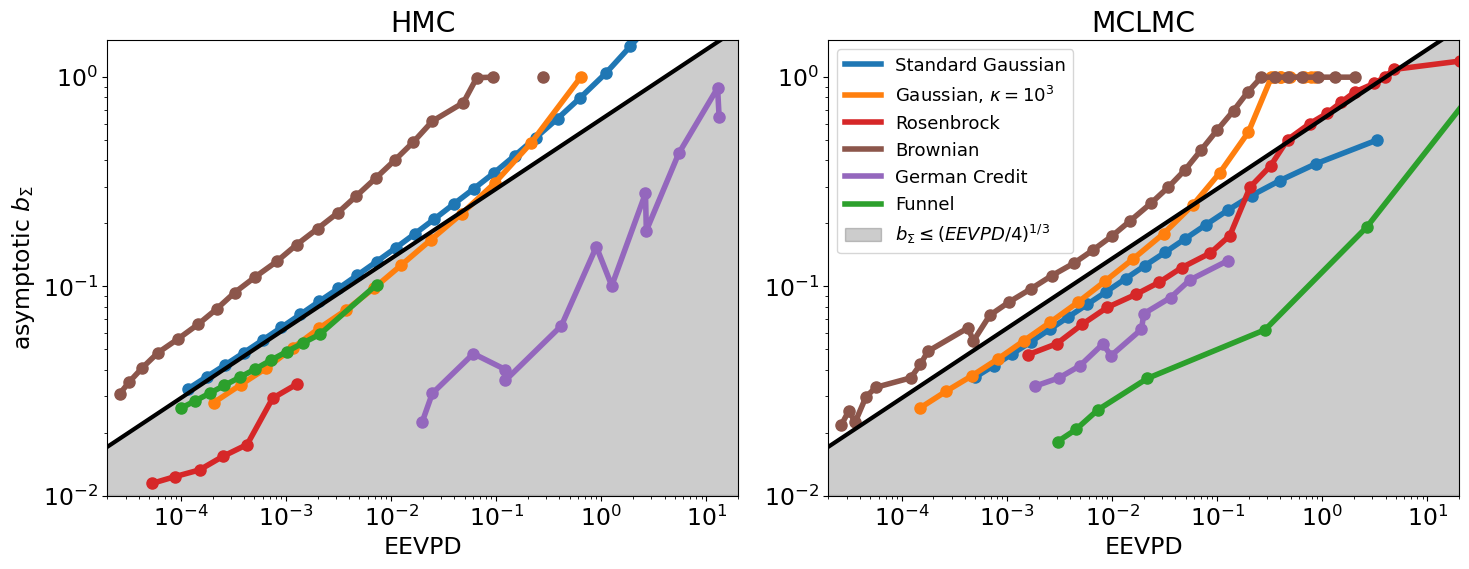

In [39]:
Method = namedtuple('Method', ['short_name', 'name'])
Target = namedtuple('Target', ['short_name', 'name', 'color', 'bound'])

methods = [Method('hmc', 'HMC'), 
           Method('mclmc', 'MCLMC')]

targets = [Target('StandardNormal', 'Standard Gaussian', 'tab:blue', [1e-4, 5e-4]), 
           Target('IllConditionedGaussian', r'Gaussian, $\kappa = 10^3$', 'tab:orange', [1.5e-4, 1e-4]),
           Target('Rosenbrock', 'Rosenbrock', 'tab:red', [4e-5, 1e-3]),
           Target('Brownian', 'Brownian', 'tab:brown', [-np.inf, -np.inf]),
           Target('GermanCredit', 'German Credit', 'tab:purple', [1e-2, 1e-3]),
           Target('FunnelWithData', 'Funnel', 'tab:green', [[1e-4, 1e-2], 2.5e-3]),
           ]

plt.figure(figsize = (15, 6))
plt.rcParams['xtick.labelsize'] = 17
plt.rcParams['ytick.labelsize'] = 17
plt.rcParams['font.size'] = 17

for i, method in enumerate(methods):
    plt.subplot(1, 2, i+1)
    plt.title(method.name)

    for target in targets:
        success, eevpd, basym = read_data('data/' +  target.short_name + '/', method.short_name)
        if success:
            bound = target.bound[i]
            if isinstance(bound, list):
                converged = (bound[0] < eevpd) & (eevpd < bound[1])
            else:
                converged = bound < eevpd
            #converged = np.ones(eevpd.shape, dtype= bool)
            plt.plot(eevpd[converged], np.sqrt(basym)[converged], 'o-', lw= 4, markersize = 8, color = target.color)
        
        
    plt.xscale('log')
    plt.yscale('log')
    ylim = plt.gca().get_ylim()
    xlim = plt.gca().get_xlim()
    E = np.logspace(np.log10(xlim[0]), np.log10(xlim[1]), 100)
    analytical = lambda E: np.power(0.25 * E, 1./3.)
    plt.plot(E, analytical(E), lw=3, color= 'black')
    plt.fill_between(E, np.ones(len(E)) * 1e-2, analytical(E), alpha = 0.2, color= 'black', label= r'$b_{\Sigma} \leq (EEVPD / 4)^{1/3}$')


    # legend
    for target in targets:
        plt.plot([], [], '-', lw= 4, color= target.color, label= target.name)
    
    if i == 0:
        plt.ylabel(r'asymptotic $b_{\Sigma}$')
    else:
        plt.legend(fontsize = 13, loc= 2)

    plt.ylim(1e-2, 1.5)
    plt.xlim(2e-5, 20)

    plt.xlabel('EEVPD')

plt.tight_layout()
plt.savefig('img/benchmarks.png')
plt.show()

In [3]:
from scipy.stats import linregress

def get_range(desired_range, method, target):
    data = np.load('../data/bias/' + method + '_' + target + '.npz')
    eps, eevpd = data['stepsize'], np.average(data['eevpd'], axis = -1)
    res = linregress(np.log(eevpd), np.log(eps))
    return np.exp(res.slope * np.log(desired_range) + res.intercept)

def plot_range(method, target):
    data = np.load('../data/bias/' + method + '_' + target + '.npz')
    eps, eevpd = data['stepsize'], np.average(data['eevpd'], axis = -1)
    res = linregress(np.log(eevpd), np.log(eps))
    eps_linfit= np.exp(res.slope * np.log(eevpd))
    
    plt.plot(eps, eevpd, 'o')
    plt.plot(eps_linfit, eevpd)
    plt.xscale('log')
    plt.yscale('log')


def plott(method, target, ieps= 0):
    data = np.load('data/' + target + '/' + method + '.npz')
    eps, eevpd = data['stepsize'], np.average(data['eevpd'], axis = -1)
    n = np.arange(1, len(data['bias'][0, 0, :])+1) * 1000
    for ichain in range(4):
        plt.plot(n, data['bias'][ieps, ichain, :])
    plt.xscale('log')
    plt.yscale('log')

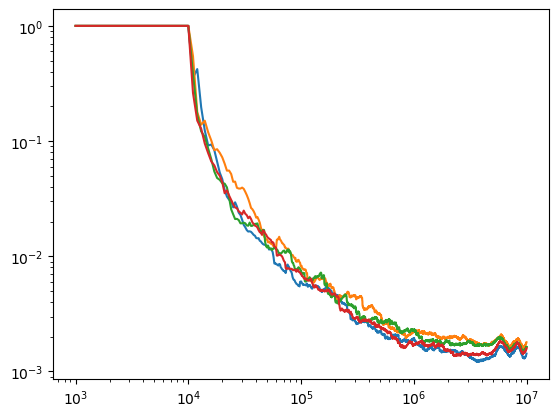

In [5]:
plott('mclmc1', 'Brownian', ieps= 5)

In [24]:
method, target = 'hmc20', 'FunnelWithData'

data = np.load('data/' + target + '/' + method + '.npz')

print(data['eevpd'][:, 0])


[4.6855646e-07 6.2941797e-07 8.6153545e-07 1.2333966e-06 1.5748718e-06
 2.1691235e-06 2.9131736e-06 3.9721831e-06 5.5845421e-06 7.7241020e-06
 1.0197026e-05 1.4026390e-05 1.9272486e-05 2.6773472e-05 3.7710874e-05
 5.0678977e-05 7.0843205e-05 9.4498137e-05 1.3678832e-04 1.8958321e-04
 2.5409379e-04 3.5762007e-04 5.0777872e-04 7.0476241e-04 1.0210576e-03
 1.5098426e-03           inf           nan           nan           nan
           nan           nan]


No handles with labels found to put in legend.


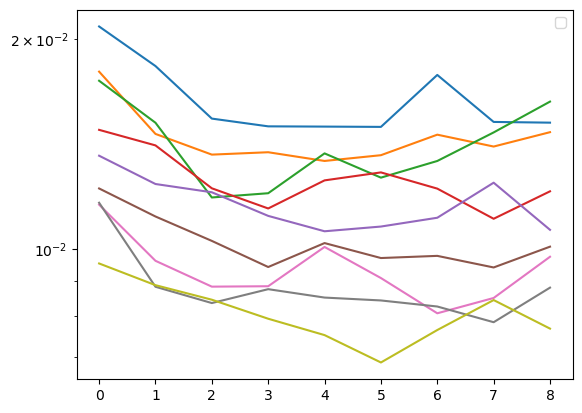

In [20]:
method, target = 'mclmc', 'Rosenbrock'
X = []
ieps = 0

for i in range(1, 10):
    data = np.load('data/' + target + '/' + method + str(i) + '.npz')
    #plt.plot(np.median(data['bias'], axis= 1)[ieps], label= str(i))
    
    X.append(np.median(np.min(data['bias'], axis = -1), axis= -1))

X = np.array(X)
#plt.plot(np.argmin(X, axis= 0))
for i in range(len(X)):
    plt.plot(X[:, i])
plt.yscale('log')
#plt.xscale('log')
plt.legend()
plt.show()

#HMC 9, 9
#MCLMC 4 2

In [ ]:

desired_range = [7e-5, 0.5]

for method, target in product(['hmc2', 'hmc3', 'mclmc1'], targets):
    try:
        print(method + ', ' + target.name, get_range(desired_range, method, target.short_name))
    except:
        print(method + ', ' + target.name)